# SNOTEL Processing for pySUMMA Modeling

This notebook pulls SNOTEL data via metloom to create a meteorological forcing file for pysumma. 7 input meteorological variables are needed at hourly (if using SNOTEL data, hourly is highest temporal resolution possible) timesteps: air temperature, precipitation, incoming shortwave radiation, incoming longwave radiation, air pressure, relative humidity, and wind speed. 

Temperature used is observed from SNOTEL with the *Currier et al. (2017)* voltage issue correction. Precipitation used is observed from SNOTEL - be wary of undercatch for upper elevation SNOTEL sites in windier locations, check to ensure accumulated precip > max SWE. Incoming shortwave radiation is empirically derived using latitude, elevation, and time of year to calculate clear sky radiation and the diurnal temperature range and precipitation to calculate the cloud correction factor with the MetSim package. Incoming longwave radiation is empirically derived from air temperature and relative humidity using the *Dilley and O'Brien (1998)* method. The empirical calculation method for incoming longwave radiation can be modified if desired - the `lw_clr.py` script in `summa_work/utils` provides a number of different methods to choose from. Relative humidity is empirically derived assuming the running 24 hour minimum temperature as the dewpoint for each timestep from *Running et al. (2017)*. Wind speed is set at 2 meters per second for every timestep as this is an incredibly difficult quantity to observe in mountainous regions during winter due to riming and other issues (*TODO - citation needed for this choice*). Air pressure is empirically derived using the hypsometric equation and scale height of the atmosphere for midlatitudes.

The data is first pulled from the NRCS API using metloom. The data is then preprocessed to fill any missing timesteps. MetSim is then used to generate the incoming shortwave radiation. Finally, the remaining meteorological variables are calculated and converted to correct units before saving as a netcdf output file conforming to pysumma naming and formatting conventions.

### How to Use
1. In the cell below, edit desired water year in cell below
2. Edit SNOTEL station ID, can look up on NRCS National Weather and Climate Center's Interactive Map
3. Edit outgoing file name - no required format, whatever you choose
4. Edit outgoing path where you would like the met forcing file for pysumma runs
5. Create the following directories for calculated SW and snotel raw data to be stored: `./input/`, `./output`, and `./snotel_csvs/`
6. Run all! 

**Clinton Alden**

**Mountain Hydrology Research Group**

**University of Washington**

In [1]:
water_year = 2018
out_name = 'snoq_WY18'
out_path = './'
snotel = '672:WA:SNTL' # example: '1259:WA:SNTL' for Muckamuck

## Use metloom API to pull snotel data

In [2]:
from datetime import datetime, timedelta
from metloom.pointdata import SnotelPointData
import pandas as pd
import cartopy
import geoviews as gv
import geopandas as gpd
import holoviews as hv
import xarray as xr
from metsim import MetSim
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from metpy.units import units
import metpy.calc as mpcalc
import math
import scipy
from pytz import UTC

import sys
sys.path.append('/Users/clintonalden/Documents/Research/summa_work/')
from utils import lw_clr
from utils import forcing_filler as ff
from utils import summa_check as sc

In [3]:
water_year_str = str(water_year)
start_year = water_year - 1
start_year_str = str(start_year)

start_date = datetime(start_year, 7, 3)
end_date = datetime(water_year, 4, 18)

spinstart = pd.to_datetime(start_year_str + '-07-03').tz_localize('UTC')
spinend = pd.to_datetime(start_year_str + '-09-30').tz_localize('UTC')

start_loc = datetime(start_year, 10, 1).replace(tzinfo=UTC)
mask_date = datetime(start_year, 10, 2).replace(tzinfo=UTC)

dates = pd.date_range('10/01/' + start_year_str, '4/18/' + water_year_str)

spin_range = pd.date_range('07/03/' + start_year_str, '09/30/' + start_year_str)

In [4]:
snoq = pd.read_csv('./snoq_WY2018.csv', index_col=0)
snoq.dropna(subset=['Year'], inplace=True)
snoq['datetime'] = pd.to_datetime(snoq['Year'].astype(int).astype(str) + snoq['DOY'].astype(int).astype(str).str.zfill(3) + (snoq['Hour']/100).astype(int).astype(str).str.zfill(2), format='%Y%j%H')
snoq.set_index('datetime', inplace=True)
snoq = snoq[['Precip', 'Temp_F']]
snoq.rename(columns={'Temp_F': 'airtemp', 'Precip':'accppt'}, inplace=True)

# convert airtemp to K
snoq['airtemp'] = (snoq['airtemp']-32)*(5/9)

# convert precip to kg m-2 s-1
snoq['accppt'] = (snoq['accppt']*25.4).cumsum() # in/hr to mm/hr
# snoq['pptrate'] = snoq['pptrate']/3600 # mm/hr to kg m-2 s-1

# fill air pressure
# ff.fill_pressure(snoq, 914)

# convert rh to specific humidity
# ff.fill_spec_hum(snoq)
# snoq.drop(columns=['rh'], inplace=True)

# df = snoq

# Specify latitude, longitude, and elevation from station metadata
lat = 47.43
lon = -121.42
elev = 1000

snoq

,accppt,airtemp
datetime,,
2017-10-01 00:00:00,0.254,5.066667
2017-10-01 01:00:00,0.508,4.694444
2017-10-01 02:00:00,1.524,5.033333
2017-10-01 03:00:00,2.286,4.900000
2017-10-01 04:00:00,2.286,5.033333
...,...,...
2018-04-18 19:00:00,2740.406,2.466667
2018-04-18 20:00:00,2740.406,1.505556
2018-04-18 21:00:00,2740.406,1.233333


In [5]:
# Pull desired variables from snotel to dataframe
snotel_point = SnotelPointData(snotel, "MyStation")
df = snotel_point.get_hourly_data(
    start_date, end_date,
    [snotel_point.ALLOWED_VARIABLES.PRECIPITATIONACCUM, snotel_point.ALLOWED_VARIABLES.TEMP, 
     snotel_point.ALLOWED_VARIABLES.SWE, snotel_point.ALLOWED_VARIABLES.SNOWDEPTH]
)

# Specify latitude, longitude, and elevation from station metadata
# lat = snotel_point.metadata.y
# lon = snotel_point.metadata.x
# elev = snotel_point.metadata.z

# Clean up the dataframe
df.reset_index(inplace=True)

# Rename columns
replace = {'ACCUMULATED PRECIPITATION':'accppt','AIR TEMP':'airtemp', 'datetime':'time'}
df.rename(columns=replace, inplace=True)
df.set_index('time', inplace=True)

# df.to_csv('./snotel_csvs/'+out_name+'.csv')
df.drop(columns=['site', 'ACCUMULATED PRECIPITATION_units', 'geometry', 'AIR TEMP_units', 'datasource', 
                 'SWE', 'SWE_units', 'SNOWDEPTH', 'SNOWDEPTH_units'], inplace=True)

## Fill missing timesteps from snotel data

In [6]:
# Convert the index of the dataframe to a DatetimeIndex
df.index = pd.to_datetime(df.index)

# Create a date range from the first to the last timestep
date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='h')

# Find the missing dates
missing_dates = date_range[~date_range.isin(df.index)]

# Print the missing dates
# print(missing_dates)

# Reindex the data DataFrame with the missing dates
# Concatenate the original DataFrame with a DataFrame containing the missing dates
new_df = pd.concat([df, pd.DataFrame(index=missing_dates)], axis=0)

# Sort the new DataFrame by the index
new_df = new_df.sort_index()
df = new_df

# Fill NaNs for every other column
df = df.fillna(np.nan)

# Rename index
df.index.name = 'time'

In [7]:
# Convert the index of the dataframe to a DatetimeIndex
snoq.index = pd.to_datetime(snoq.index)

# Create a date range from the first to the last timestep
date_range = pd.date_range(start=snoq.index.min(), end=snoq.index.max(), freq='h')

# Find the missing dates
missing_dates = date_range[~date_range.isin(snoq.index)]

# Print the missing dates
print(missing_dates)

# Reindex the data DataFrame with the missing dates
# Concatenate the original DataFrame with a DataFrame containing the missing dates
new_df = pd.concat([snoq, pd.DataFrame(index=missing_dates)], axis=0)

# Sort the new DataFrame by the index
new_df = new_df.sort_index()
snoq = new_df

# Fill NaNs for every other column
snoq = snoq.fillna(np.nan)

# Rename index
snoq.index.name = 'time'

DatetimeIndex([], dtype='datetime64[ns]', freq='h')


## Unit Conversions

In [8]:
# Covert air temperature to celsius
df['airtemp'] = (df['airtemp'] - 32) * 5.0/9.0

# Convert precipitation to mm
df['accppt'] = df['accppt'] * 25.4

# Convert from geodataframe to dataframe
df = pd.DataFrame(df)


## Split up data into spinup state and desired date range for MetSim

In [9]:
df_slice = df.loc['2017-07-03 08:00:00':'2017-09-30 23:00:00']
snoq_slice = snoq.loc['2017-10-01 00:00:00':'2018-04-18 23:00:00']

result = pd.concat([df_slice, snoq_slice], axis=0)
df = result

In [10]:
df.index = pd.to_datetime(df.index, utc=True)

In [11]:
df

,accppt,airtemp
time,,
2017-07-03 08:00:00+00:00,2984.500,10.800000
2017-07-03 09:00:00+00:00,2981.960,10.000000
2017-07-03 10:00:00+00:00,2981.960,9.600000
2017-07-03 11:00:00+00:00,2981.960,9.300000
2017-07-03 12:00:00+00:00,2981.960,8.900000
...,...,...
2018-04-18 19:00:00+00:00,2740.406,2.466667
2018-04-18 20:00:00+00:00,2740.406,1.505556
2018-04-18 21:00:00+00:00,2740.406,1.233333


In [12]:
# Interpolate the missing values
df.interpolate(inplace=True)

# Seperate the data into two dataframes, before and after October 1
spinstart = pd.to_datetime('2017-07-03').tz_localize('UTC')
spinend = pd.to_datetime('2017-09-30').tz_localize('UTC')
spinup = df.loc[spinstart:spinend].copy()
data = df.loc[start_loc:]

# Copy the dataframe a2 to a2_copy
data_copy = data.copy()

# Create a mask to identify rows where the index is less than or equal to October 2, 2023
mask = data_copy.index <= mask_date

# Set the 'precip_accum' column to 0 for rows that satisfy the mask condition
data_copy.loc[mask, 'accppt'] = 0

# Update the value of a2 to the modified copy
data = data_copy

# Calculate the difference between the maximum value of 'precip_accum' and the previous value
spinup['pptrate'] = spinup['accppt'].cummax().diff()
data['pptrate'] = data['accppt'].cummax().diff()

# Drop accppt column
spinup.drop(columns=['accppt'], inplace=True)
data.drop(columns=['accppt'], inplace=True)

## Generate SW from MetSim

In [13]:
# Create empty dataset
shape = (len(dates), 1, 1, )
dims = ('time', 'lat', 'lon', )

# We are running only one site, at these coordinates
lats = [lat]
lons = [lon]
elev = elev # meters
coords = {'time': dates, 'lat': lats, 'lon': lons}

# Create the initial met data input data structure
met_data = xr.Dataset(coords=coords)

In [14]:
for varname in ['prec', 't_min', 't_max']:
    met_data[varname] = xr.DataArray(data=np.full(shape, np.nan),
                                     coords=coords, dims=dims,
                                     name=varname)

In [15]:
# Resample the data to daily frequency and calculate the maximum and minimum temperatures
tmax_vals = data['airtemp'].resample('D').max()
tmin_vals = data['airtemp'].resample('D').min()

# Calculate the daily precipitation values
prec_vals = data['pptrate'].resample('D').sum()

# Interpolate the temperature values to fill in any missing days
# tmax_vals = tmax_vals.interpolate(method='linear')
# tmin_vals = tmin_vals.interpolate(method='linear')

met_data['prec'].values[:, 0, 0] = prec_vals

# Assign the daily maximum and minimum temperatures to the met_data xarray, converting to Celsius
met_data['t_min'].values[:, 0, 0] = tmin_vals
met_data['t_max'].values[:, 0, 0] = tmax_vals

met_data.to_netcdf('./input/rc_forcing.nc')

In [16]:
# We form the domain in a similar fashion
# First, by creating the data structure
coords = {'lat': lats, 'lon': lons}
domain = xr.Dataset(coords=coords)
domain['elev'] = xr.DataArray(data=np.full((1,1,), np.nan),
                          coords=coords,
                          dims=('lat', 'lon', ))
domain['mask'] = xr.DataArray(data=np.full((1,1,), np.nan),
                          coords=coords,
                          dims=('lat', 'lon', ))

# Add the data
domain['elev'][0, 0] = elev
domain['mask'][0, 0] = 1
domain.to_netcdf('./input/rc_domain.nc')

In [17]:
# Finally, we create the state file - the dates are 90 days prior to 
# the MetSim run dates - as usual, create an empty data structure to
# read the data into
shape = (len(spin_range), 1, 1, )
dims = ('time', 'lat', 'lon', )
coords = {'time': spin_range, 'lat': lats, 'lon': lons}
state = xr.Dataset(coords=coords)
for varname in ['prec', 't_min', 't_max']:
    state[varname] = xr.DataArray(data=np.full(shape, np.nan),
                               coords=coords, dims=dims,
                               name=varname)
    
# Resample precip to daily
prec_vals = spinup['pptrate'].resample('D').sum()

# Resample the data to daily frequency and calculate the maximum and minimum temperatures
tmax_vals = spinup['airtemp'].resample('D').max()
tmin_vals = spinup['airtemp'].resample('D').min()

# Do precip data
state['prec'].values[:, 0, 0] = prec_vals

# And now temp data and convert to C
state['t_min'].values[:, 0, 0] = tmin_vals
state['t_max'].values[:, 0, 0] = tmax_vals
state.to_netcdf('./input/rc_state.nc')

In [18]:
# dates = pd.date_range('10/01/2014', '09/30/2015')
params = {
    'time_step'    : "60",       
    'start'        : dates[0],
    'stop'         : dates[-1],
    'forcing'      : './input/rc_forcing.nc',     
    'domain'       : './input/rc_domain.nc',
    'state'        : './input/rc_state.nc',
    'forcing_fmt'  : 'netcdf',
    'out_dir'      : './output',
    'out_prefix': out_name,
    'scheduler'    : 'threading',
    'chunks'       : 
        {'lat': 1, 'lon': 1},
    'forcing_vars' : 
        {'prec' : 'prec', 't_max': 't_max', 't_min': 't_min'},
    'state_vars'   : 
        {'prec' : 'prec', 't_max': 't_max', 't_min': 't_min'},
    'domain_vars'  : 
        {'elev': 'elev', 'lat': 'lat', 'lon': 'lon', 'mask': 'mask'}
    }               

ms = MetSim(params)
ms.run()
output = ms.open_output().load()

## Create SUMMA forcing netCDF

In [19]:
out_df = output.to_dataframe()
out_df.reset_index(inplace=True)
out_df.set_index('time', inplace=True)

In [20]:
# Remove timezone from index
data.index = data.index.tz_convert(None)

# Convert precipitation rate from mm hr^-1 to kg m^-2 s^-1
data['pptrate'] = data['pptrate']/3600

# Generate relative humidity assuming T_d is overnight low temperature
# Used to calculate specific humidity and longwave radiation
ff.fill_rel_hum(data)

# Convert airtemp to Kelvin
data['airtemp'] = (1.03*(data['airtemp']-0.9)) + 273.15 # Currier snotel temp correction

# Generate pressure from hypsometric equation and site elevation (1981m)
ff.fill_pressure(data, elev)

# Generate specific humidity
ff.fill_spec_hum(data)
data['spechum'] = data['spechum'].clip(lower=0.001)


# Set shortwave radiation to MetSim output
data['SWRadAtm'] = out_df['shortwave']

# Generate longwave radiation
data['LWRadAtm'] = lw_clr.dilleyobrien1998(data['airtemp'], data['rh'])

# Can alternatively use the MetSim LW radiation
# data['LWRadAtm'] = out_df['longwave']

# Set wind to 2 m/s
data['windspd'] = 2

# Fill in missing values
data['pptrate'] = data['pptrate'].fillna(0)

# Drop unnecessary columns
data = data.drop(columns=['rh'])

# Interpolate the missing values
data.interpolate(inplace=True)

In [21]:
# Load template forcing file to preserve attributes
template = xr.open_dataset('../summa_forcing_template.nc')

# Convert dataframe to xarray
dsx = data.to_xarray()

# Loop through variables and add attributes from template forcing file
for data_var in dsx:
    dsx[data_var].attrs = template[data_var].attrs
    
# Add hru dimension
dsx = dsx.expand_dims(dim={'hru':1})

# Add gap-filled and datastep variables
dsx['gap_filled'] = xr.DataArray(np.ones((1,dsx.time.shape[0])),dims = ['hru','time'])
dsx['data_step'] = 3600 # 3600 seconds for 1hr timesteps

# Transpose gap filled variable to match dimensions with the rest
# dsx['gap_filled'] = dsx['gap_filled'].T

# Convert all to float64
for var in dsx.data_vars:
    dsx[var] = dsx[var].astype(np.float64)

# Set hruID based on template
dsx['hruId'] = (xr.DataArray(np.ones((1))*template['hruId'].values,dims = ['hru'])).astype(np.int32)

# Transpose all variables to match SUMMA dimensions
count = 0
for var in dsx.data_vars:
    # print(var,count)
    count += 1
    if count <= 7:
        attribs = dsx[var].attrs
        arr_t = dsx[var].values.T
        dsx[var] = xr.DataArray(dims = ['time','hru'],data = arr_t)
        dsx[var].attrs = attribs

# Set encoding for the time variable
# dsx['time'].encoding = {'_FillValue': np.nan, 'units': 'hours since 1990-01-01', 'calendar': 'proleptic_gregorian'}

# Set hruID based on template
dsx['hruId'] = (xr.DataArray(np.ones((1))*template['hruId'].values,dims = ['hru'])).astype(np.float64).fillna(0).astype(np.int32)

dsx.to_netcdf(out_path+out_name+'.nc',
                        encoding = {"time":
                                        {'dtype' : 'float64',
                                         'units' : 'hours since 1990-01-01 00:00:00',
                                         'calendar' : 'standard'}})

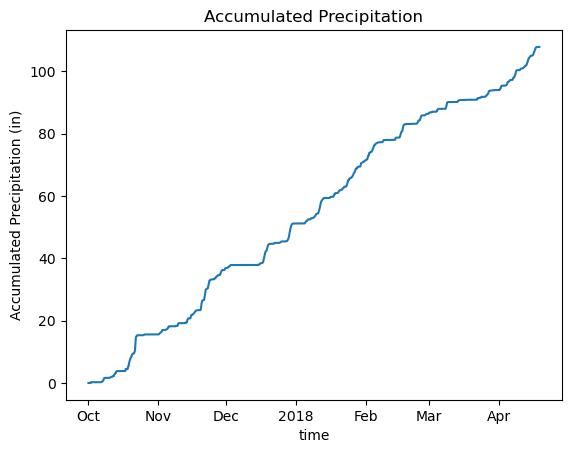

In [27]:
(dsx.pptrate.cumsum()*3600/25.4).plot()
plt.ylabel('Accumulated Precipitation (in)')
plt.title('Accumulated Precipitation')
plt.show()

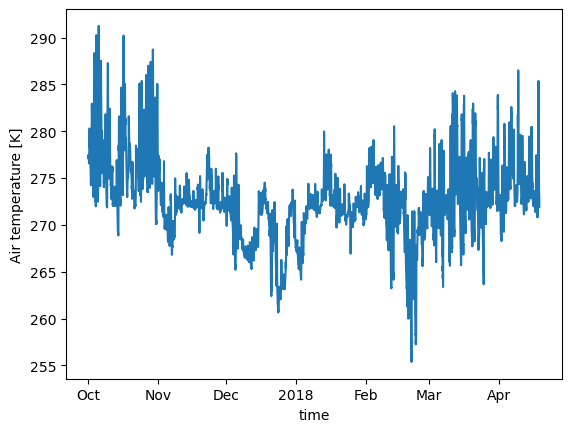

In [28]:
dsx.airtemp.plot()